<a href="https://colab.research.google.com/github/nishamuktewar/test/blob/master/snorkel_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 102kB 37.9MB/s 
     |████████████████████████████████| 829kB 55.7MB/s 
     |████████████████████████████████| 5.7MB 41.3MB/s 
     |████████████████████████████████| 12.9MB 49.1MB/s 
     |████████████████████████████████| 3.3MB 54.0MB/s 
     |████████████████████████████████| 17.3MB 56.0MB/s 
     |████████████████████████████████| 204kB 63.6MB/s 
     |████████████████████████████████| 61kB 29.5MB/s 
     |████████████████████████████████| 24.8MB 1.3MB/s 
     |████████████████████████████████| 5.9MB 48.0MB/s 
     |████████████████████████████████| 51kB 21.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
  Stored in directory: /root/.cache/pip/wheels/38/80/04/b2dbcd5df8afdb529918d2021094048a5917b6e76a6f7b452d
  Stored in directory: /root/.cache/pip/wheels/6b/02/e3/7f1149be63131cdf6aaaa3330924a2683bb530188940569d66
  Stored in directory: /root/.cache/pip/wheels/b4/db/8a/3a3f0c0

In [2]:
!pip3 install git+https://github.com/HazyResearch/snorkel

  Cloning https://github.com/HazyResearch/snorkel to /tmp/pip-req-build-00x9satp
  Running command git clone -q https://github.com/HazyResearch/snorkel /tmp/pip-req-build-00x9satp
  Stored in directory: /tmp/pip-ephem-wheel-cache-dz3aj9cq/wheels/62/6f/22/444271063e7be3c3547fd48ba1782c8053489be0e0226990b0
Successfully built snorkel


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import os

In [6]:
!pip3 install treedlib

In [7]:
!pip3 install numbskull

In [8]:
from sklearn.model_selection import train_test_split
from collections import Counter
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass, Context, Candidate, StableLabel
from snorkel.contrib.models.text import RawText
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals
from snorkel.learning.tensorflow import TextRNN

W0627 17:46:31.018722 140534982911872 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    !curl https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD > ./data/complaints.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  721M    0  721M    0     0  7857k      0 --:--:--  0:01:34 --:--:-- 6200k


In [10]:
complaints = pd.read_csv(os.path.join(data_dir,'complaints.csv'))
complaints.info()
complaints.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318982 entries, 0 to 1318981
Data columns (total 18 columns):
Date received                   1318982 non-null object
Product                         1318982 non-null object
Sub-product                     1083816 non-null object
Issue                           1318982 non-null object
Sub-issue                       783385 non-null object
Consumer complaint narrative    391465 non-null object
Company public response         468379 non-null object
Company                         1318982 non-null object
State                           1298328 non-null object
ZIP code                        1198657 non-null object
Tags                            180500 non-null object
Consumer consent provided?      713360 non-null object
Submitted via                   1318982 non-null object
Date sent to company            1318982 non-null object
Company response to consumer    1318975 non-null object
Timely response?                1318982 non-null obj

(1318982, 18)

In [0]:
products_w_narrative = complaints[complaints['Product'].notnull() & 
                                  complaints['Consumer complaint narrative'].notnull()]

In [12]:
print(products_w_narrative['Product'].unique())
print(products_w_narrative['Product'].value_counts())

['Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Checking or savings account'
 'Vehicle loan or lease' 'Student loan'
 'Payday loan, title loan, or personal loan' 'Mortgage'
 'Money transfer, virtual currency, or money service' 'Credit reporting'
 'Credit card' 'Bank account or service' 'Consumer Loan' 'Prepaid card'
 'Money transfers' 'Payday loan' 'Other financial service'
 'Virtual currency']
Credit reporting, credit repair services, or other personal consumer reports    95835
Debt collection                                                                 88284
Mortgage                                                                        53652
Credit reporting                                                                31588
Credit card or prepaid card                                                     22208
Student loan                                                                    22161
Cre

In [0]:
# credit reporting only
credit_reporting = products_w_narrative[products_w_narrative['Product'] == 'Credit reporting, ' + 
                                 'credit repair services, or other personal consumer reports']
# mortgage only
mortgage = products_w_narrative[products_w_narrative['Product'] == 'Mortgage']

In [0]:
credit_narrative = credit_reporting['Consumer complaint narrative'].values
positive_labels = pd.Series(np.ones(credit_narrative.shape[0]))
positive_df = pd.DataFrame({'complaint': credit_narrative, 'label': positive_labels})

In [0]:
mortgage_narrative = mortgage['Consumer complaint narrative'].values
negative_labels = pd.Series(np.full(mortgage_narrative.shape[0], -1))
negative_df = pd.DataFrame({'complaint': mortgage_narrative, 'label': negative_labels})

In [16]:
complaints_df = pd.concat([positive_df, negative_df], ignore_index=True)
complaints_df.shape

(149487, 2)

In [17]:
complaints_df['label'].value_counts()

 1.0    95835
-1.0    53652
Name: label, dtype: int64

In [0]:
train, testval = train_test_split(complaints_df, test_size=0.2, random_state=123)
dev, test = train_test_split(testval, test_size=0.5, random_state=123)

In [0]:
POSITIVE_WORDS = r'\bcredit\b|\breport|\baddress\b|\bcreditor\b|\bexperian\b|\btransunion\b|\bequifax\b|\bfcra\b|\bcollector\b|\bdebt\b|\bconsumer\b'              
POSITIVE_PHRASE = r"\bcredit (report|agency|reporting|bureau|agencies)"
NEGATIVE_WORDS = r'\bloan\b|\bmortgage\b|\bhouse\b|\bhome\b|\bprepayment\b|\bappraise|\bforeclos\btax'
POSITIVE_ACTIONS = r'\bremov|\bdispute\b'
NEGATIVE_ACTIONS = r'\bpredator|\bmodifi\brefinanc'

FRAUD = r'\bfraudulent (account|charges)'
MONEYXFER = r'\bmoney transfer'
CREDIT_REPORTING = r'\b(identity has been compromise(|d)|data breaches|inquiries to businesses|mistakes appear in my report|reporting incorrectly|dispute(|d)|(t|T)ransunion|derogatory|experian|identity theft)'
CREDIT_REPAIR = r'\b(credit repair|hard inquiry|inquiries to businesses|mistakes appear in my report|reporting incorrectly)'


In [0]:
def lf_credit(complaint):
    if re.search(POSITIVE_WORDS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_phrase(complaint):
    if re.search(POSITIVE_PHRASE, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_actions(complaint):
    if re.search(POSITIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_mortgage(complaint):
    if re.search(NEGATIVE_WORDS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0

def lf_mortgage_actions(complaint):
    if re.search(NEGATIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0
    
def lf_fraud(complaint):
    if (re.search(FRAUD, str(complaint), re.IGNORECASE)
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(FRAUD, str(complaint), re.IGNORECASE) 
          and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_reporting(complaint):
    if (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_repair(complaint):
    if (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE) 
        and not re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)
       ):
        return 1
    elif ((re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)) 
          or 
          (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE))
         ):
        return -1
    else:
        return 0

In [21]:
session = SnorkelSession()

values = list(complaints_df.label.unique())
print(values)

# snorkel candidate, value if none defaults to binary (true, false)
Narrative = candidate_subclass('Narrative', ['narrative'], values=values)

# Make sure DB is cleared
session.query(Context).delete()
session.query(Candidate).delete()
session.query(StableLabel).delete()

[1.0, -1.0]


0

In [22]:
train_index = train.index
train.index.str = np.asarray(str(x) for x in train.index)
train_complaints = train.values[:, 0]
train_labels = train.values[:, 1]

for element in zip(train_index, train_complaints, train_labels):
    split = 0
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=0,
                            value=element[2]))
dev_index = dev.index
dev.index.str = np.asarray(str(x) for x in dev.index)
dev_complaints = dev.values[:, 0]
dev_labels = dev.values[:, 1]

for element in zip(dev_index, dev_complaints, dev_labels):
    split = 1
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=1,
                            value=element[2]))

test_index = test.index
test.index.str = np.asarray(str(x) for x in test.index)
test_complaints = test.values[:, 0]
test_labels = test.values[:, 1]

for element in zip(test_index, test_complaints, test_labels):
    split = 2
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=2,
                            value=element[2]))

session.commit()

# number of datapoints
print(session.query(Narrative).count())
# load ground truth labels
train_cand_labels = train_labels
dev_cand_labels = dev_labels
test_cand_labels = test_labels

149487


In [23]:
# test one labeling function
labeled = []
for c in session.query(Narrative).filter(Narrative.split == 1).all():
    if lf_credit(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

Number labeled: 11218


In [24]:
LFs = [lf_credit, lf_credit_phrase, lf_credit_actions, lf_mortgage, lf_mortgage_actions, lf_fraud, lf_reporting, lf_repair]
# apply labeling functions
labeler = LabelAnnotator(lfs = LFs)
L_train = labeler.apply(split=0)

  0%|          | 30/119589 [00:00<06:45, 294.59it/s]

Clearing existing...
Running UDF...


100%|██████████| 119589/119589 [06:45<00:00, 295.14it/s]


In [25]:
# see what's going on
print(L_train.get_candidate(session, 0))
print(L_train.get_key(session, 0))
print(L_train.lf_stats(session))


Narrative(Raw Text BANK OF AMERICA required me to apply for the Hardest Hit Fund before they would assist me with a loan modification. Once my loan was current because of the Hardest Hit funds, BOA refused to give me loan modifications options I could have qualified for with my loan current and up to date because of the Hardest Hit funds. My only income is XXXX and child support. They have increased my income by 125 % to determine my new monthly mortgage payment because they claim it is not taxable. 
Even with this inflated amount, they are proposing a 90 day trial where I make a mortgage payment to BOA that is 39.75 % of this inflated gross income figure they have come up with. 
It 's 56 % of the net income that my family has to live on each month. I do n't see how this is an FHA compliant modification. Because I asked a question about the income numbers they used, BOA is trying to claim I 've opted out of the trial offered. I did not XXXX out of anything. BOA asked me to fax my inqui

In [26]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=20, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


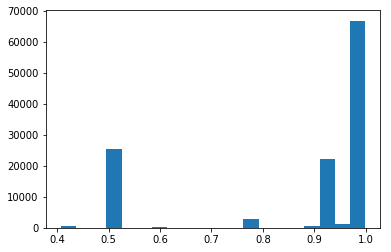

In [27]:
train_marginals = gen_model.marginals(L_train)
plt.hist(train_marginals, bins=20)
plt.show()

In [28]:
accuracy = gen_model.score(L_train, train_cand_labels)
accuracy[0]
print("precision: {:.5f}".format(accuracy[0]), "recall: {:.5f}".format(accuracy[1]), 
      "F-beta: {:.5f}".format(accuracy[2]))

precision: 0.64810 recall: 0.96872 F-beta: 0.77662


In [29]:
# Collect the majority vote answer for each complaint
mv = []
for i in range(L_train.shape[0]):
    if np.diff(L_train[i].indptr) != 0:   #indicates that there is no coverage for a particular datapoint
        c = Counter([L_train[i,j] for j in L_train[i].nonzero()[1]])
        #print(c)
        mv.append(c.most_common(1)[0][0])
        #print(c.most_common(1)[0][0])
    else:
        mv.append(-1) # assume that no label is equivalent to a negative example

mv = np.array(mv)

# Count the number correct by majority vote
n_correct = np.sum([1 for i in range(L_train.shape[0]) if mv[i] == train_cand_labels[i]])
print ("Accuracy:{}".format(n_correct / float(L_train.shape[0])))
print ("Number incorrect:{}".format(L_train.shape[0] - n_correct))

# Compute and return precision, recall, and F1 score
tp = (0.5 * (mv * train_cand_labels + 1))[mv == 1].sum()
pred_pos = mv[mv == 1].sum()
p = tp / float(pred_pos) if pred_pos > 0 else 0.0
pos = train_cand_labels[train_cand_labels == 1].sum()
r = tp / float(pos) if pos > 0 else 0.0

# Compute general F-beta score
beta=1
if p + r > 0:
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r))
else:
    f_beta = 0.0
p, r, f_beta
print("precision: {:.5f}".format(p), "recall: {:.5f}".format(r), "F-beta: {:.5f}".format(f_beta))


Accuracy:0.8140548043716396
Number incorrect:22237
precision: 0.79189 recall: 0.96237 F-beta: 0.86885


In [30]:
L_dev = labeler.apply(split=1)
# score it
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_cand_labels)

Clearing existing...


  0%|          | 31/14949 [00:00<00:48, 308.02it/s]

Running UDF...


100%|██████████| 14949/14949 [00:50<00:00, 297.71it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.966
Neg. class accuracy: 0.0626
Precision            0.648
Recall               0.966
F1                   0.775
----------------------------------------
TP: 9254 | FP: 5032 | TN: 336 | FN: 327



In [31]:
save_marginals(session, L_train, train_marginals)

Saved 119589 marginals


In [0]:
train_cands = session.query(Narrative).filter(Narrative.split == 0).order_by(Narrative.id).all()
dev_cands   = session.query(Narrative).filter(Narrative.split == 1).order_by(Narrative.id).all()
test_cands  = session.query(Narrative).filter(Narrative.split == 2).order_by(Narrative.id).all()


In [0]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.2,
    'print_freq': 5,
    'seed': 123,
    'batch_size': 25
}

lstm = TextRNN(seed=123, cardinality=Narrative.cardinality)
# Note: Y_train are the marginals but Y_dev are the gold/ ground truth labels
lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, Y_dev=dev_cand_labels, **train_kwargs)

/usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:36: UserWarning: Candidate 117068 has argument past max length for model:	[arg ends at index 5542; max len 5542]
  warnings.warn('\t'.join([w.format(i), info]))
W0627 18:10:52.368278 140534982911872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/noise_aware_model.py:114: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0627 18:10:52.369294 140534982911872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:70: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 18:10:52.381653 140534982911872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:79: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0627 18:10:52.3995

[TextRNN] Training model
[TextRNN] n_train=114919  #epochs=10  batch size=25


In [0]:
accuracy_dev = lstm.score(dev_cands, dev_cand_labels)
print("precision: {:.5f}".format(accuracy_dev[0]), "recall: {:.5f}".format(accuracy_dev[1]), 
      "F-beta: {:.5f}".format(accuracy_dev[2]))

In [0]:
accuracy_test = lstm.score(test_cands, test_cand_labels)
print("precision: {:.5f}".format(accuracy_test[0]), "recall: {:.5f}".format(accuracy_test[1]), 
      "F-beta: {:.5f}".format(accuracy_test[2]))